# Hypothesis testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('salaries_final.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior-level,Full-time,Business Intelligence Engineer,202800.0,USD,202800.0,United States,On-site,United States,Large
1,2023,Senior-level,Full-time,Business Intelligence Engineer,104300.0,USD,104300.0,United States,On-site,United States,Large
2,2023,Mid-level,Full-time,Data Manager,60000.0,GBP,73824.0,United Kingdom,On-site,United Kingdom,Medium
3,2023,Mid-level,Full-time,Data Manager,55000.0,GBP,67672.0,United Kingdom,On-site,United Kingdom,Medium
4,2023,Senior-level,Full-time,Data Scientist,290000.0,USD,290000.0,United States,On-site,United States,Medium


In [3]:
df.shape

(7974, 11)

## Tests

**TEST #1**

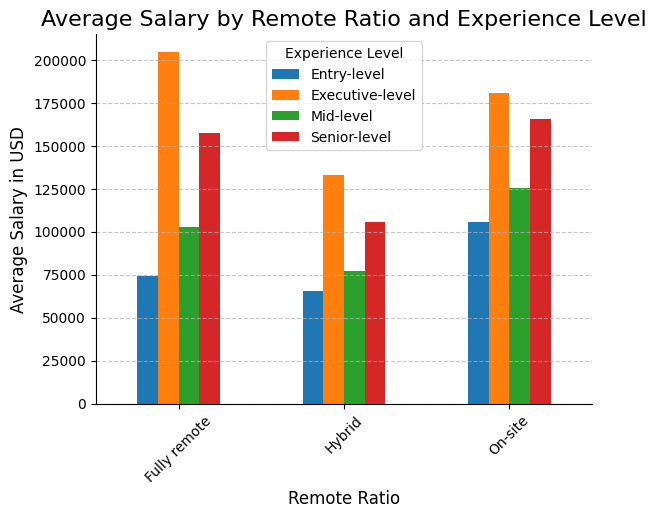

In [4]:
# Group and plot
df.groupby(['remote_ratio', 'experience_level'])['salary_in_usd'].mean().unstack().plot(kind='bar')

# Add labels and titles
plt.title('Average Salary by Remote Ratio and Experience Level', fontsize=16)
plt.xlabel('Remote Ratio', fontsize=12)
plt.ylabel('Average Salary in USD', fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add legend
plt.legend(title='Experience Level', fontsize=10)

# Show plot
plt.show()

### 1. Question: Is mid-level people working on a hybrid type of work get paid less than people working on Fully remote or On-site?

**Null Hypothesis**: Mid-level people working on a hybrid type of work get paid the same as people working on Fully remote or On-site.

**Alternative Hypothesis**: Mid-level people working on a hybrid type of work get paid less than people working on Fully remote or On-site.

Threshold (alpha) = 5%

Countries to consider = all

In [5]:
hybrid_salaries = df[(df['remote_ratio'] == 'Hybrid') & (df['experience_level'] == 'Mid-level')]['salary_in_usd']
non_hybrid_salaries = df[(df['remote_ratio'] != 'Hybrid') & (df['experience_level'] == 'Mid-level')]['salary_in_usd']

hybrid_salaries.shape, non_hybrid_salaries.shape

((85,), (1461,))

Text(0.5, 1.0, 'Average Salary For Mid-level')

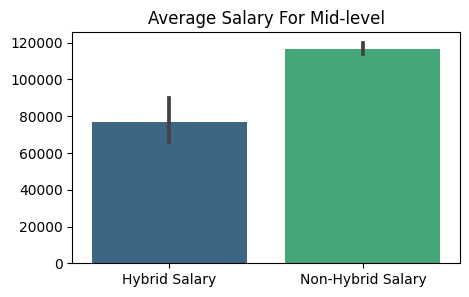

In [6]:
plt.figure(figsize=(5,3))

sns.barplot(pd.DataFrame([hybrid_salaries.to_list(), non_hybrid_salaries.to_list()]).T.rename(columns={0:'Hybrid Salary', 1:'Non-Hybrid Salary'}), palette='viridis')

plt.title('Average Salary For Mid-level')

#### Imbalanced data

1. `Bootstrap` - Resample with replacement from both groups. This can help in estimating the sampling distribution and confidence intervals.

In [7]:
def bootstrap(data, num_samples=1000):
    sample_means = []
    for _ in range(num_samples):
        sample = data.sample(len(data), replace=True)
        sample_means.append(np.mean(sample))
    return sample_means

hybrid_bootstrap_means = bootstrap(hybrid_salaries)
non_hybrid_bootstrap_means = bootstrap(non_hybrid_salaries)

Text(0.5, 1.0, 'Average Salary For Mid-level (BOOTSTRAP)')

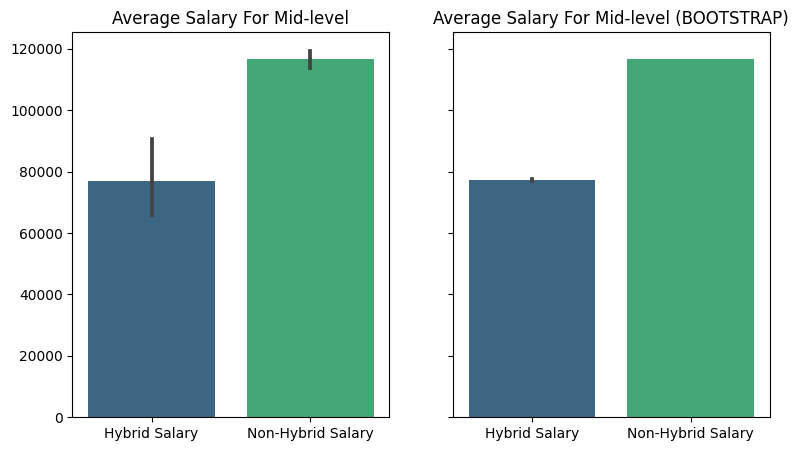

In [8]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(9,5))

sns.barplot(pd.DataFrame([hybrid_salaries.to_list(), non_hybrid_salaries.to_list()]).T.rename(columns={0:'Hybrid Salary', 1:'Non-Hybrid Salary'}), palette='viridis', ax=axs[0])

axs[0].set_title('Average Salary For Mid-level')

sns.barplot(pd.DataFrame([hybrid_bootstrap_means, non_hybrid_bootstrap_means]).T.rename(columns={0:'Hybrid Salary', 1:'Non-Hybrid Salary'}), palette='viridis', ax=axs[1])

axs[1].set_title('Average Salary For Mid-level (BOOTSTRAP)')

In [9]:
# Perform t-test
statistic, p_value = stats.ttest_ind(hybrid_bootstrap_means, non_hybrid_bootstrap_means)

# Define significance level (alpha)
alpha = 0.05

# Print results
print(f'Test Statistic: {statistic}')
print(f'P-Value: {p_value}')

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in salaries.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in salaries.")

Test Statistic: -195.80359000108808
P-Value: 0.0
Reject null hypothesis: There is a significant difference in salaries.


2. `stats.mannwhitneyu` is a non-parametric test that can be used to compare two independent samples.

In [10]:
# Perform Mann-Whitney U Test
U_statistic, p_value = stats.mannwhitneyu(hybrid_salaries, non_hybrid_salaries, alternative='less')

# Define significance level (alpha)
alpha = 0.05

# Print results
print(f'U Statistic: {U_statistic}')
print(f'P-Value: {p_value}')

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in salaries.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in salaries.")


U Statistic: 31062.5
P-Value: 4.389528944824211e-15
Reject null hypothesis: There is a significant difference in salaries.


#### The result

Because of the high imbalance in the data, I cannot consider this answer as right.

**Reject null hypothesis: There is a significant difference in salaries.**

**TEST #2**

In [11]:
df[(df['company_location'] != df['employee_residence']) & (df['experience_level'] == 'Entry-level')].salary_in_usd.mean()

56436.86842105263

In [12]:
df[(df['company_location'] == df['employee_residence']) & (df['experience_level'] == 'Entry-level')].salary_in_usd.mean()

89040.56265984655

### 2. Question: Do entry-level residents of other countries receive lower wages than citizens of the company's country?

**Null Hypothesis**: Entry-level residents of other countries do not receive lower wages than citizens of the company's country.

**Alternative Hypothesis**: Entry-level residents of other countries receive lower wages than citizens of the company's country.

Threshold (alpha) = 5%

Countries to consider = all

In [13]:
residents = df[(df['company_location'] == df['employee_residence']) & (df['experience_level'] == 'Entry-level')]['salary_in_usd']
non_residents = df[(df['company_location'] != df['employee_residence']) & (df['experience_level'] == 'Entry-level')]['salary_in_usd']

residents.shape, non_residents.shape

((391,), (38,))

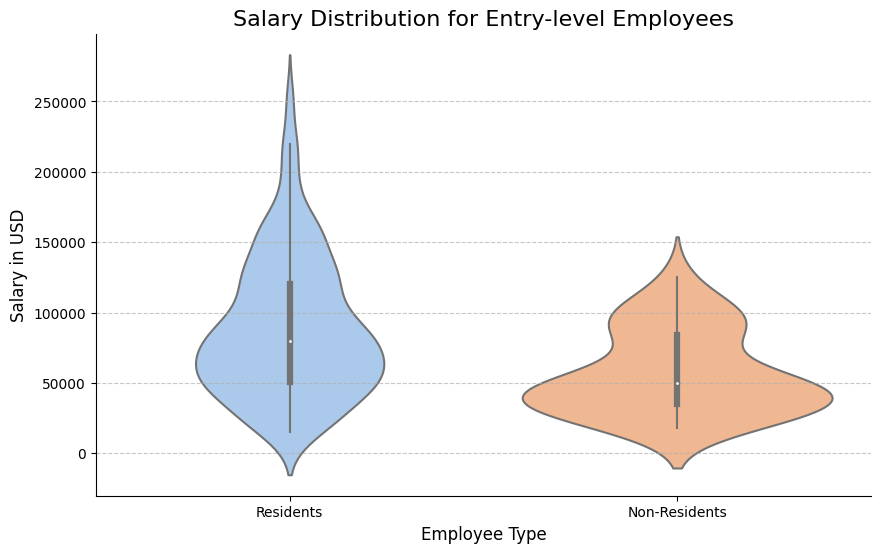

In [14]:
# Combine data for plotting
data = [residents, non_residents]
labels = ['Residents', 'Non-Residents']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a violin plot
sns.violinplot(data=data, ax=ax, palette='pastel')

# Add title and labels
plt.title('Salary Distribution for Entry-level Employees', fontsize=16)
plt.xlabel('Employee Type', fontsize=12)
plt.ylabel('Salary in USD', fontsize=12)

# Customize x-axis labels
ax.set_xticklabels(labels, fontsize=10)

# Add a grid for better visibility
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()

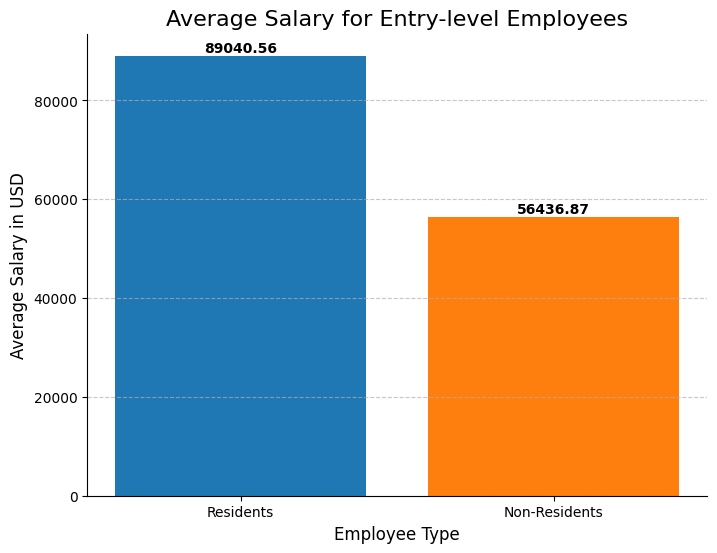

In [15]:
residents_mean = residents.mean()
non_residents_mean = non_residents.mean()

fig, ax = plt.subplots(figsize=(8, 6))

x = ['Residents', 'Non-Residents']
y = [residents_mean, non_residents_mean]

bars = plt.bar(x, y, color=['#1f77b4', '#ff7f0e'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='k', fontweight='bold')

plt.title('Average Salary for Entry-level Employees', fontsize=16)
plt.xlabel('Employee Type', fontsize=12)
plt.ylabel('Average Salary in USD', fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#### Imbalanced data

In [16]:
# Perform Mann-Whitney U Test
U_statistic, p_value = stats.mannwhitneyu(residents, non_residents, alternative='less')

# Define significance level (alpha)
alpha = 0.05

# Print results
print(f'U Statistic: {U_statistic}')
print(f'P-Value: {p_value}')

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: Entry-level residents of other countries receive lower wages than citizens of the company's country.")
else:
    print("Fail to reject null hypothesis: Entry-level residents of other countries do not receive lower wages than citizens of the company's country.")

U Statistic: 10427.0
P-Value: 0.9999802296162821
Fail to reject null hypothesis: Entry-level residents of other countries do not receive lower wages than citizens of the company's country.


### The result

**Fail to reject null hypothesis: Entry-level residents of other countries do not receive lower wages than citizens of the company's country.**